In [2]:
#'''
import numpy as np
import pandas as pd
import pyjags
import pystan
import stan_utility_copy
import pickle
import matplotlib.pyplot as plt
#import matplotlib as plt
#'''
from pystan import StanModel
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole





In [3]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this workbook.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    #print(x)
    for i in range(0, Ndata): 
            #print(i)
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

In [4]:
## Below we designate the population values of our two-component truncated Gaussian 
## generative model. These are the truths that we should recover if our hiararchical 
## Bayesian model is properly specified and diagnostics have indicated that the simulation 
## has "not not converged".
Ndata = 25
Nm = 2
frac = [0.7,0.3]
sigmae = [0.05,0.3]

## After generating values from the population model, we now add realistic Gaussian noise 
## to create simulated measurements. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)

for i in range(0,Ndata):
    #print('i')
    #print(i)
    
    c = np.random.choice(len(frac), 1, p=frac, replace=True)
    #print(int(c))
    h[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=-1,upper_bound=1)
    # Euler's formula: h^2 + k^2 = 1
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

    
print(h, hhat, k, khat)
print(k.shape)

[ 0.06371717  0.08790979 -0.01013498 -0.03705594 -0.03282299 -0.1000776
 -0.18120188 -0.10898204  0.0354974   0.03093616 -0.06156238 -0.01096054
 -0.04805347 -0.03513338 -0.01376716  0.59511088 -0.0011852  -0.26595204
  0.04970645  0.02630385  0.01630993 -0.22659476 -0.02730419  0.36858626
  0.04267604] [ 0.03669806  0.0873228   0.04305855 -0.03181227 -0.00266985 -0.13316879
 -0.21336798 -0.15890144  0.05646899  0.03133642 -0.00524999 -0.08231737
  0.01346569 -0.0300555  -0.00259453  0.60591321 -0.02316046 -0.22172817
  0.06974849  0.05491864  0.01576472 -0.28481118 -0.08735134  0.39327459
 -0.00980571] [-0.04014436 -0.05027956 -0.02448466 -0.08103521  0.05468679  0.00334642
 -0.52424354 -0.58669365 -0.06225289  0.12580995 -0.00492546 -0.01564013
  0.10683596  0.11728518  0.0891867   0.0480842  -0.12205185  0.02756316
 -0.0679424  -0.02675047  0.16213238 -0.10471107 -0.06295021  0.12686264
 -0.06769397] [ 0.11867356 -0.11547841  0.04917476 -0.01629976  0.01550692 -0.03140517
 -0.399459

(array([  3.,   2.,   5.,  12.,   1.,   0.,   0.,   1.,   0.,   1.]),
 array([-0.28481118, -0.19573874, -0.1066663 , -0.01759387,  0.07147857,
         0.16055101,  0.24962345,  0.33869589,  0.42776833,  0.51684077,
         0.60591321]),
 <a list of 10 Patch objects>)

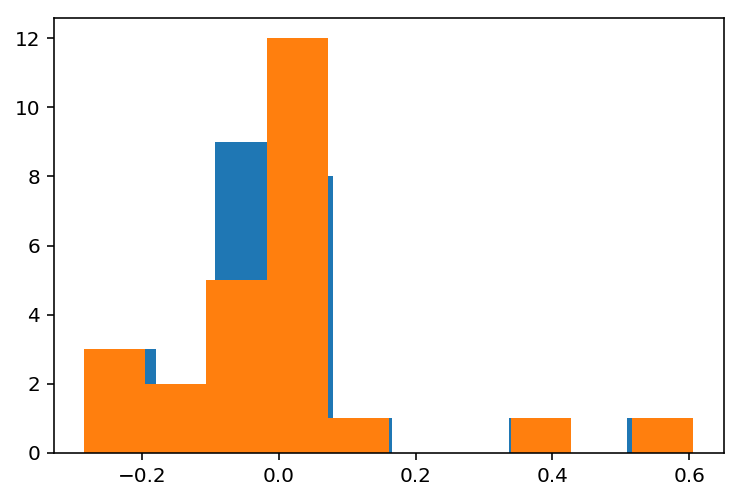

In [5]:
plt.hist(h)
plt.hist(hhat)

(array([ 1.,  1.,  0.,  0.,  0.,  4.,  3.,  4.,  8.,  4.]),
 array([-0.51562854, -0.44753732, -0.37944611, -0.31135489, -0.24326368,
        -0.17517246, -0.10708124, -0.03899003,  0.02910119,  0.0971924 ,
         0.16528362]),
 <a list of 10 Patch objects>)

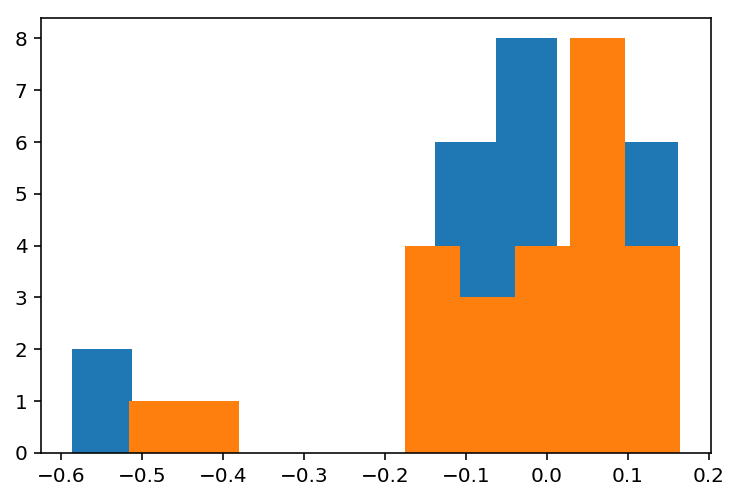

In [6]:
plt.hist(k)
plt.hist(khat)

In [7]:
'''
## One-component Gaussian Mixture Simulated Data
## Below we designate the population values of our generative model. These are the 
## truths that we should recover if our hiararchical Bayesian model is properly specified 
## and diagnostics have indicated that the simulation has "not not converged". "You can't 
## prove convergence, at best you can fail to prove a failure to converge".

## In this simulated data set, their are 50 planetary systems (with one planet each)
Ndata = 25 
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recovern 
sigmae = 0.3 
## We approximate the uncertainty for each measurement as normally distributed about a 
## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter
## the physical models used to derive these produce larger uncertainty in k by a factor of 2. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)


for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae,lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat, k, khat)
plt.hist(h)
plt.hist(hhat)
'''

'\n## One-component Gaussian Mixture Simulated Data\n## Below we designate the population values of our generative model. These are the \n## truths that we should recover if our hiararchical Bayesian model is properly specified \n## and diagnostics have indicated that the simulation has "not not converged". "You can\'t \n## prove convergence, at best you can fail to prove a failure to converge".\n\n## In this simulated data set, their are 50 planetary systems (with one planet each)\nNdata = 25 \n## Here we asign the dispersion of the simulated population to be 0.3, this is \n## the truth we wish to recovern \nsigmae = 0.3 \n## We approximate the uncertainty for each measurement as normally distributed about a \n## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter\n## the physical models used to derive these produce larger uncertainty in k by a factor of 2. \nsigmahobs = 0.04\nsigmakobs = 0.08\n\nh = np.repeat(0.,Ndata)\nk = np.repeat(0.,Ndata)\nhhat

In [8]:
%%time
!date

eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
    real<lower=-1,upper=1> khat[Ndata];
    real<lower=0,upper=1> khat_sigma[Ndata];

}
parameters {
    //real<lower=0,upper=1> f;
    simplex[Nm] f;
    real<lower=0> e_sigma[Nm];
    real<lower=-1,upper=1> h[Ndata];
    real<lower=-1,upper=1> k[Ndata];
}
model {
    e_sigma ~ uniform(0, 1.0);
    
    hhat ~ normal(h, hhat_sigma);
    khat ~ normal(k, khat_sigma);

    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(h[n] | 0.0, e_sigma[1]), normal_lpdf(h[n] | 0.0, e_sigma[2]));
    for (n in 1:Ndata)
      target += log_mix(f[1], normal_lpdf(k[n] | 0.0, e_sigma[1]), normal_lpdf(k[n] | 0.0, e_sigma[2]));
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)

!date

Thu Jan 25 17:23:41 PST 2018
Thu Jan 25 17:24:49 PST 2018
CPU times: user 1.71 s, sys: 368 ms, total: 2.07 s
Wall time: 1min 8s


In [9]:
%%time
!date
ecc_dat = {'Nm': 2, 'Ndata': len(hhat), 'alpha': [1], 'hhat': hhat, 'hhat_sigma': hhat_sigma, 'khat': khat, 'khat_sigma': khat_sigma}


fit = sm.sampling(data=ecc_dat, iter=1000, chains=5, seed=483892929, refresh=1000, n_jobs=-1)

!date

Thu Jan 25 17:25:33 PST 2018
Thu Jan 25 17:26:09 PST 2018
CPU times: user 58.8 ms, sys: 59.8 ms, total: 119 ms
Wall time: 35.9 s


In [10]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

a = fit.extract(permuted=False)

#print(la)



In [11]:
## I found Python stan_utility on Jeff Alstott's github: https://github.com/jeffalstott/pystan_time_series
## I am refereing to the Stan Case Studies for HMC diagnostics in pystan:
## http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

help(stan_utility_copy)

Help on module stan_utility_copy:

NAME
    stan_utility_copy

FILE
    /Users/meganshabram/Dropbox/Graduate_School/ecc_dist_Stan_example/stan_utility_copy.py

DESCRIPTION
    #Copyright 2017 Columbia University, 2017 Jeff Alstott
    #
    #Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
    #
    #1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    #
    #2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    #
    #3. Neither the name of the copyright holder nor the name INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE 

Inference for Stan model: anon_model_60de1f1b699925c181cab11cf8f7a2fa.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]         0.38    0.11    0.2   0.13   0.24   0.32   0.48   0.82    3.0   1.88
f[1]         0.62    0.11    0.2   0.18   0.52   0.68   0.76   0.87    3.0   1.88
e_sigma[0]   0.27    0.07   0.14   0.01   0.22   0.28   0.35   0.56    4.0    1.7
e_sigma[1]    0.1    0.07   0.13   0.01   0.03   0.04   0.07   0.43    3.0   2.44
h[0]         0.02  5.9e-4   0.03  -0.03-1.5e-3   0.01   0.04   0.09 2500.0    1.0
h[1]         0.05  1.3e-3   0.04  -0.01   0.02   0.05   0.08   0.14  991.0   1.01
h[2]         0.02  6.2e-4   0.03  -0.03 6.3e-4   0.02   0.04   0.09 2500.0    1.0
h[3]        -0.01  5.7e-4   0.03  -0.08  -0.03  -0.01 4.2e-3   0.04 2500.0    1.0
h[4]      -1.5e-3  5.6e-4   0.03  -0.06  -0.02-8.4e-5   0.02   0.05 2500.0 

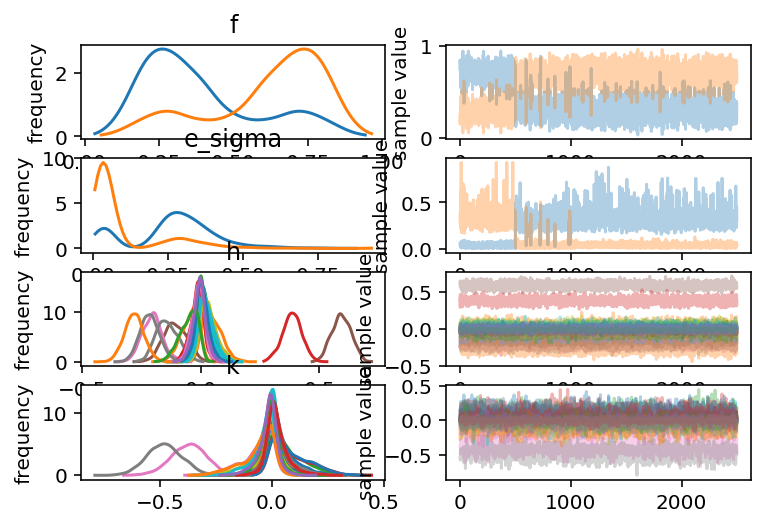

In [12]:
print(fit)
stan_utility_copy.check_treedepth(fit)
stan_utility_copy.check_energy(fit)
stan_utility_copy.check_div(fit)
fig = fit.traceplot()

(2488,)
(12,)
(2488,)
(12,)


Text(0,0.5,u'e_sigma')

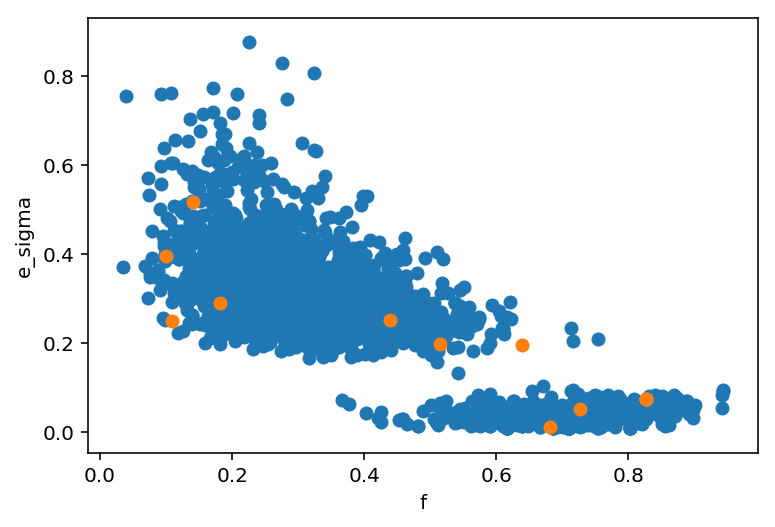

In [13]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility_copy.partition_div(fit)
print(nondiv_params['e_sigma'][:,0].shape)
print(div_params['e_sigma'][:,0].shape)
print(nondiv_params['f'][:,0].shape)
print(div_params['f'][:,0].shape)
#plt.scatter([x[0] for x in nondiv_params['f'][:,0]], nondiv_params['e_sigma'][:,0], \
             #color = mid_highlight, alpha=0.05)
#plt.scatter([x[0] for x in div_params['f'][:,0]], div_params['e_sigma'][:,0], \
             #color = green, alpha=0.5)

plt.scatter(nondiv_params['f'][:,0], nondiv_params['e_sigma'][:,0])
plt.scatter(div_params['f'][:,0], div_params['e_sigma'][:,0])

plt.gca().set_xlabel("f")
plt.gca().set_ylabel("e_sigma")



In [14]:
%%time
fit2 = sm.sampling(data=ecc_dat, iter=10000, chains=5, seed=483892929, refresh=1000, n_jobs=-1, control=dict(adapt_delta=0.99))


CPU times: user 981 ms, sys: 277 ms, total: 1.26 s
Wall time: 20min 23s


Inference for Stan model: anon_model_60de1f1b699925c181cab11cf8f7a2fa.
5 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=25000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]         0.44    0.09   0.22   0.13   0.26   0.38   0.64   0.85    6.0   1.61
f[1]         0.56    0.09   0.22   0.15   0.36   0.62   0.74   0.87    6.0   1.61
e_sigma[0]   0.23    0.06   0.16 8.7e-3   0.05   0.25   0.33   0.54    6.0   1.62
e_sigma[1]   0.14    0.06   0.15 4.5e-3   0.03   0.05   0.26   0.48    6.0   1.84
h[0]         0.02  1.9e-4   0.03  -0.03-1.7e-3   0.01   0.03   0.09  25000    1.0
h[1]         0.05  6.0e-4   0.04  -0.01   0.02   0.05   0.08   0.14 4644.0    1.0
h[2]         0.02  1.9e-4   0.03  -0.03 1.2e-4   0.02   0.04   0.09  25000    1.0
h[3]        -0.02  1.8e-4   0.03  -0.08  -0.03  -0.01 2.8e-3   0.04  25000    1.0
h[4]      -1.3e-3  1.7e-4   0.03  -0.06  -0.02-8.0e-4   0.01   0.06  25

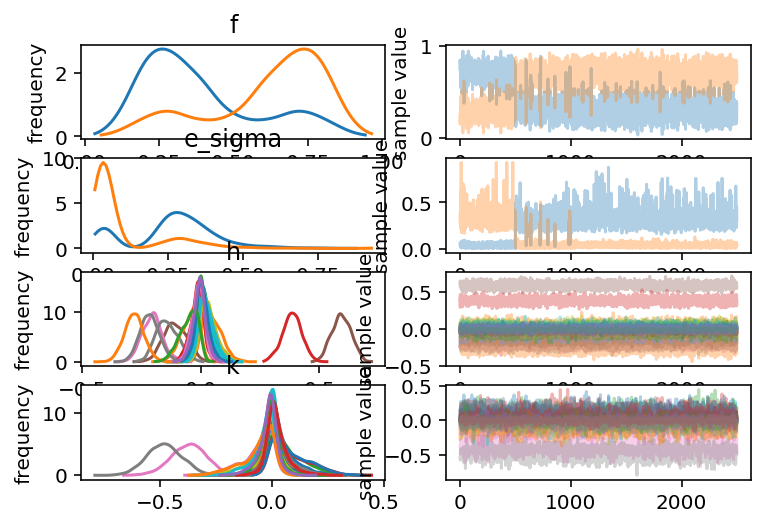

In [15]:
print(fit2)
stan_utility_copy.check_treedepth(fit2)
stan_utility_copy.check_energy(fit2)
stan_utility_copy.check_div(fit2)
fig = fit.traceplot()

(24792,)
(208,)
(24792,)
(208,)


Text(0,0.5,u'e_sigma')

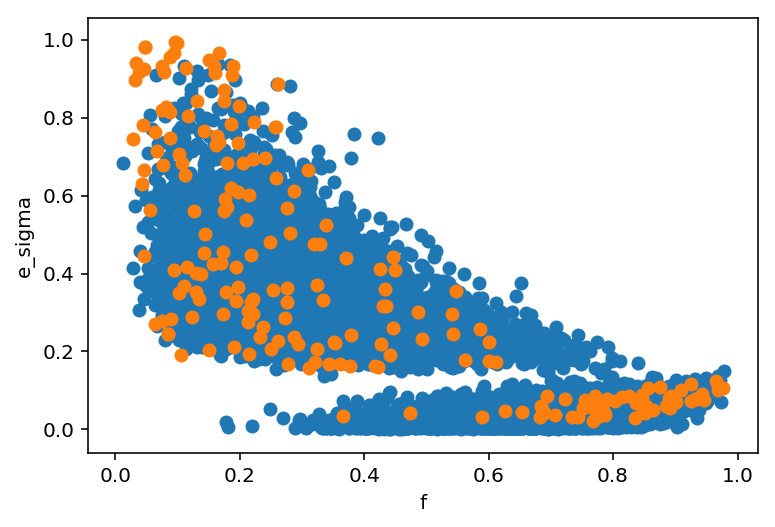

In [16]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility_copy.partition_div(fit2)
print(nondiv_params['e_sigma'][:,0].shape)
print(div_params['e_sigma'][:,0].shape)
print(nondiv_params['f'][:,0].shape)
print(div_params['f'][:,0].shape)
#plt.scatter([x[0] for x in nondiv_params['f'][:,0]], nondiv_params['e_sigma'][:,0], \
             #color = mid_highlight, alpha=0.05)
#plt.scatter([x[0] for x in div_params['f'][:,0]], div_params['e_sigma'][:,0], \
             #color = green, alpha=0.5)

plt.scatter(nondiv_params['f'][:,0], nondiv_params['e_sigma'][:,0])
plt.scatter(div_params['f'][:,0], div_params['e_sigma'][:,0])

plt.gca().set_xlabel("f")
plt.gca().set_ylabel("e_sigma")


In [17]:
num_chains = 5
samples_Stan = fit2.extract(permuted=True)
print(type(samples_Stan['e_sigma'][:,0]))
print(samples_Stan.items())

for j, i in samples_Stan.items():
    print(j)
    print(i.shape)
    



<type 'numpy.ndarray'>
[(u'f', array([[ 0.56432703,  0.43567297],
       [ 0.73999392,  0.26000608],
       [ 0.71645867,  0.28354133],
       ..., 
       [ 0.20558686,  0.79441314],
       [ 0.56132704,  0.43867296],
       [ 0.32816923,  0.67183077]])), (u'e_sigma', array([[ 0.00477651,  0.28333713],
       [ 0.06913096,  0.3659383 ],
       [ 0.03849837,  0.26765393],
       ..., 
       [ 0.44951639,  0.04701906],
       [ 0.1756838 ,  0.00245572],
       [ 0.28766773,  0.03435701]])), (u'h', array([[-0.00715306,  0.02065766,  0.0035561 , ...,  0.02603876,
         0.38085877, -0.00190851],
       [ 0.05725083,  0.04768044,  0.05019325, ..., -0.07264684,
         0.3744401 ,  0.03698285],
       [ 0.00904897,  0.0734088 ,  0.00410822, ..., -0.07283082,
         0.39724867,  0.02772442],
       ..., 
       [ 0.03137513,  0.0504065 ,  0.0699362 , ..., -0.08344457,
         0.31677817, -0.02130353],
       [ 0.00294349,  0.06179006,  0.06194723, ..., -0.10170136,
         0.35057901

In [18]:

e_sigma_1 = samples_Stan['e_sigma'][:,0]
f_1 = samples_Stan['f'][:,0]
e_sigma_2 = samples_Stan['e_sigma'][:,1]
f_2 = samples_Stan['f'][:,1]

print( np.hstack(( f_1.reshape(-1,1), e_sigma_1.reshape(-1,1), f_2.reshape(-1,1), e_sigma_2.reshape(-1,1) )) ) 

# Sort the sigma high and sigma low values:
e_sigma_low = np.minimum(e_sigma_1,e_sigma_2)
e_sigma_hi = np.maximum(e_sigma_1,e_sigma_1)
 
e_sigma_low = np.where(e_sigma_1 <= e_sigma_2, e_sigma_1, e_sigma_2)
e_sigma_hi = np.where(e_sigma_1 > e_sigma_2, e_sigma_1, e_sigma_2)
f_low = np.where(e_sigma_1 <= e_sigma_2, f_1, f_2)
f_high = np.where(e_sigma_1 > e_sigma_2, f_1, f_2)

print( np.hstack(( f_low.reshape(-1,1), e_sigma_low.reshape(-1,1), f_high.reshape(-1,1), e_sigma_hi.reshape(-1,1) )) ) 


[[ 0.56432703  0.00477651  0.43567297  0.28333713]
 [ 0.73999392  0.06913096  0.26000608  0.3659383 ]
 [ 0.71645867  0.03849837  0.28354133  0.26765393]
 ..., 
 [ 0.20558686  0.44951639  0.79441314  0.04701906]
 [ 0.56132704  0.1756838   0.43867296  0.00245572]
 [ 0.32816923  0.28766773  0.67183077  0.03435701]]
[[ 0.56432703  0.00477651  0.43567297  0.28333713]
 [ 0.73999392  0.06913096  0.26000608  0.3659383 ]
 [ 0.71645867  0.03849837  0.28354133  0.26765393]
 ..., 
 [ 0.79441314  0.04701906  0.20558686  0.44951639]
 [ 0.43867296  0.00245572  0.56132704  0.1756838 ]
 [ 0.67183077  0.03435701  0.32816923  0.28766773]]


In [19]:
## Print and check the shape of the resultant samples dictionary:
#print(samples)
#print(samples.items())
print('-----')
print(samples_Stan['e_sigma'].shape)
print(samples_Stan['h'].shape)
print(samples_Stan['h'][:,3].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm2_Stan = {}

## adjust the thin varible to only look at every #th population element 
thin1 = 1

## Need to enter the number of hyperparameter variables here:
numHyperParams = 4

## Specify the dimension we want for our plot below, for legibility.  
dim1 = (Ndata/thin1) + numHyperParams
print(dim1)

for i in np.arange(0,Ndata,thin1):
    samples_Nm2_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i],'$k_{'+str(i+1)+'}$': samples_Stan['k'][:,i]})
## Add the hyperparameter marginal posterior back in:
samples_Nm2_Stan.update({'$e_{\sigma_{low}}$': e_sigma_low})
samples_Nm2_Stan.update({'$e_{\sigma_{high}}$': e_sigma_hi})
samples_Nm2_Stan.update({'$f_{low}$': f_low})
samples_Nm2_Stan.update({'$f_{high}$': f_high})
#print(samples_Nm2_Stan['$h_{5}$'].shape)

## Reshape values for diagnostic plot functions (trace, autocorrelation) below:  
samples_Nm2_trace_Stan = {}    
for j, i in samples_Nm2_Stan.items():
    samples_Nm2_trace_Stan.update({str(j): i.reshape(int(len(i)/num_chains),-1)})


-----
(25000, 2)
(25000, 25)
(25000,)
-----
29.0


Tue Jan 30 16:28:14 PST 2018
Variable
$e_{\sigma_{high}}$    0.323164
$e_{\sigma_{low}}$     0.038289
$f_{high}$             0.305730
$f_{low}$              0.694270
$h_{10}$               0.015008
$h_{11}$              -0.002385
$h_{12}$              -0.047755
$h_{13}$               0.006476
$h_{14}$              -0.014502
$h_{15}$              -0.001099
$h_{16}$               0.594755
$h_{17}$              -0.011022
$h_{18}$              -0.213707
$h_{19}$               0.037339
$h_{1}$                0.017641
$h_{20}$               0.027575
$h_{21}$               0.007262
$h_{22}$              -0.278630
$h_{23}$              -0.051876
$h_{24}$               0.385583
$h_{25}$              -0.004699
$h_{2}$                0.052040
$h_{3}$                0.021184
$h_{4}$               -0.015153
$h_{5}$               -0.001339
$h_{6}$               -0.106960
$h_{7}$               -0.204585
$h_{8}$               -0.141423
$h_{9}$                0.029499
$k_{10}$               0.014586
$k

//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


CPU times: user 1min 48s, sys: 4.23 s, total: 1min 52s
Wall time: 2min 1s


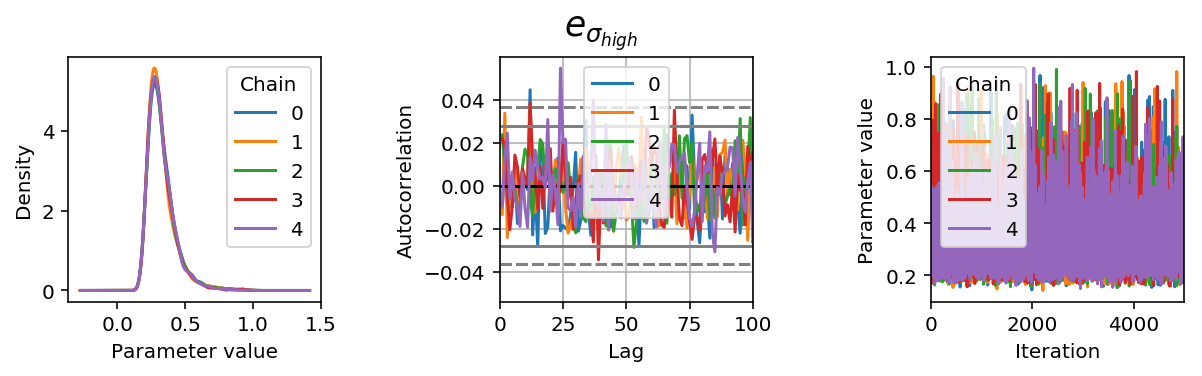

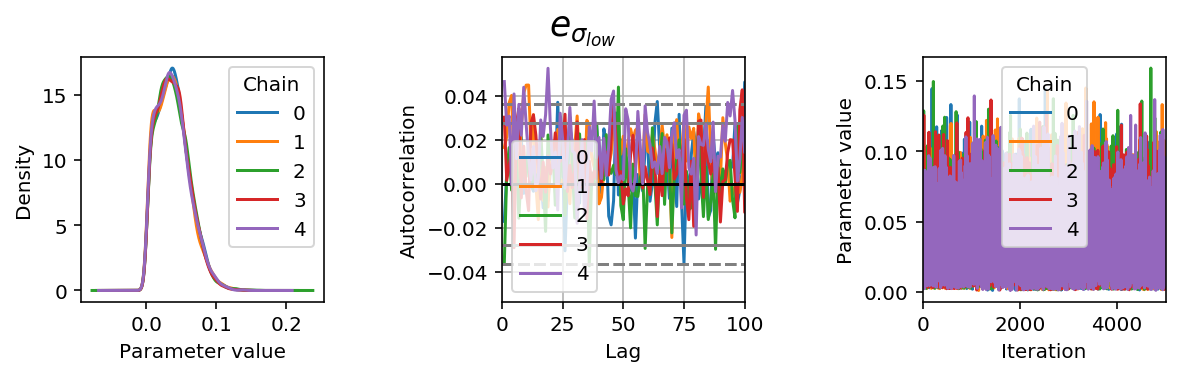

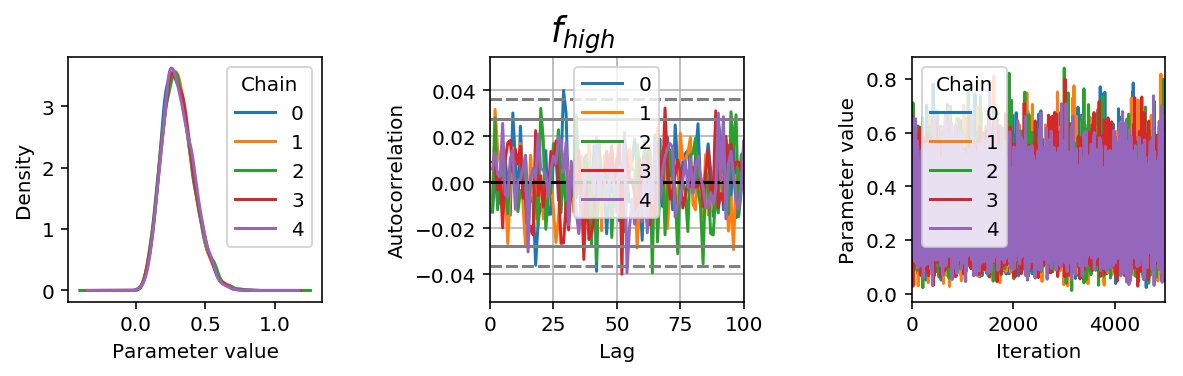

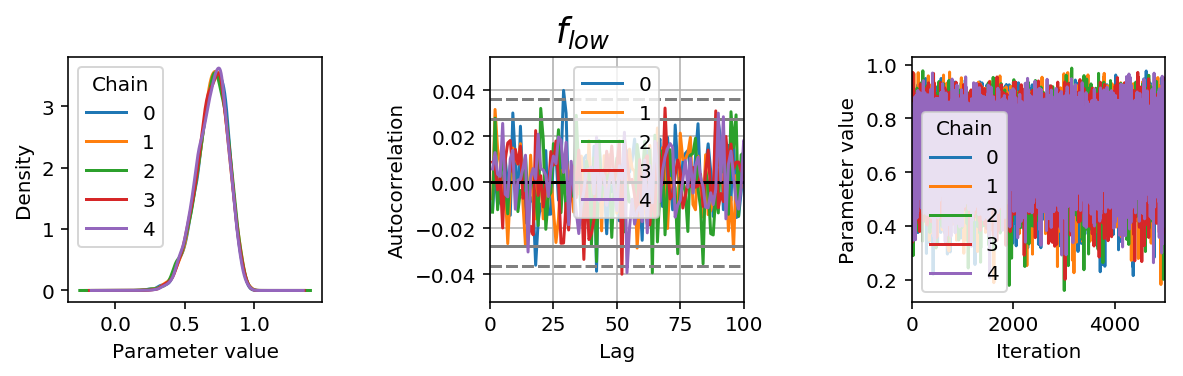

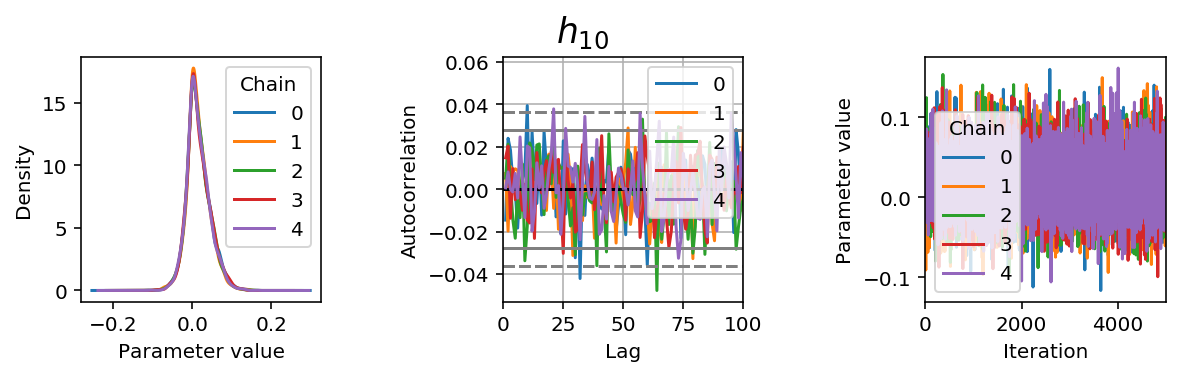

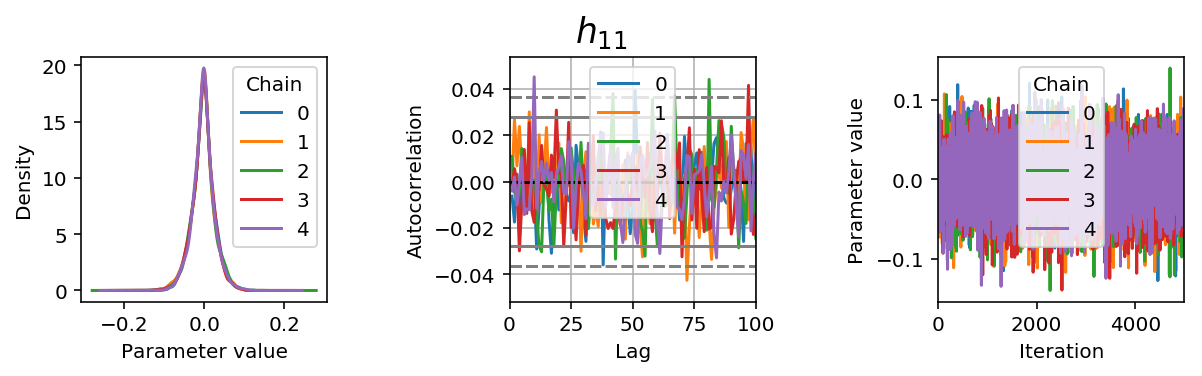

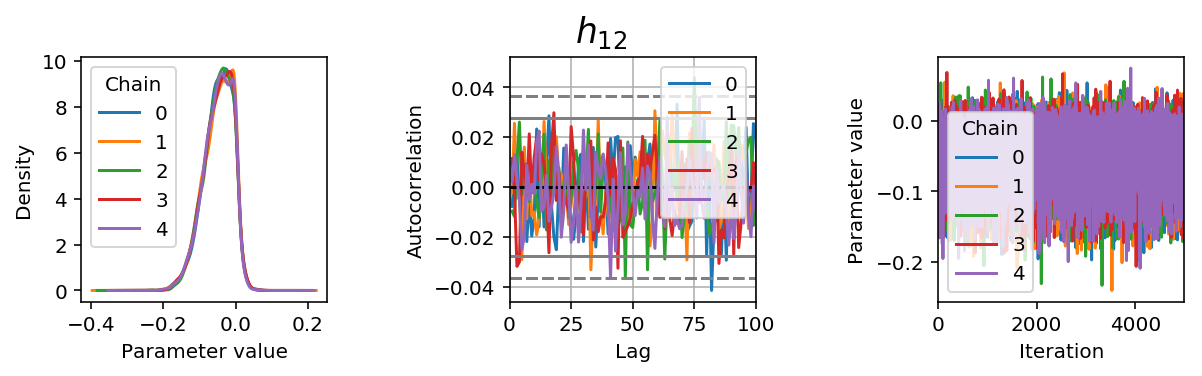

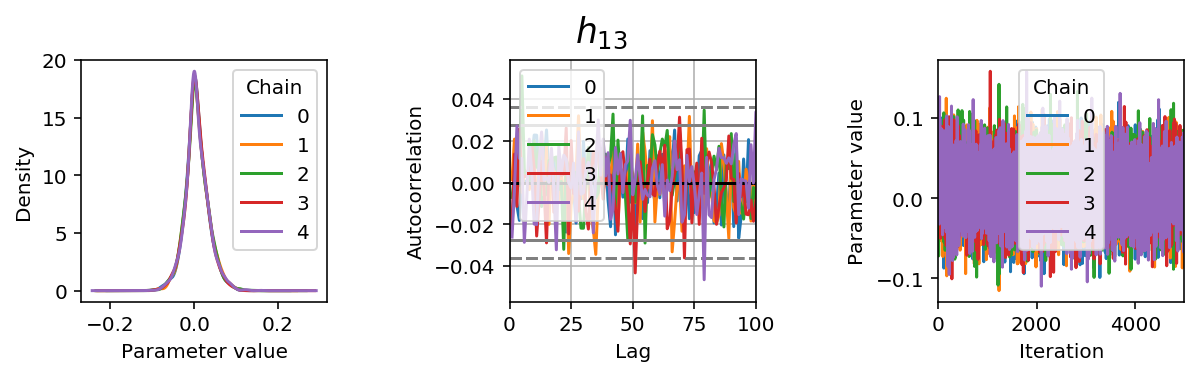

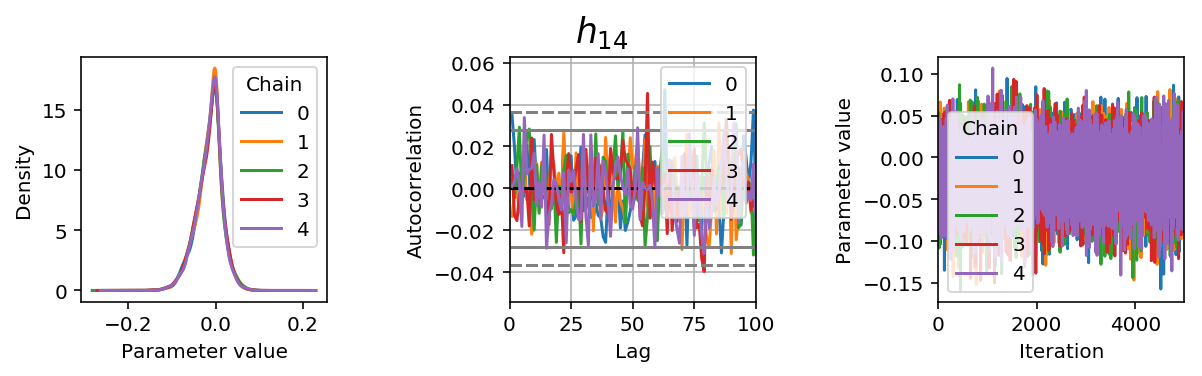

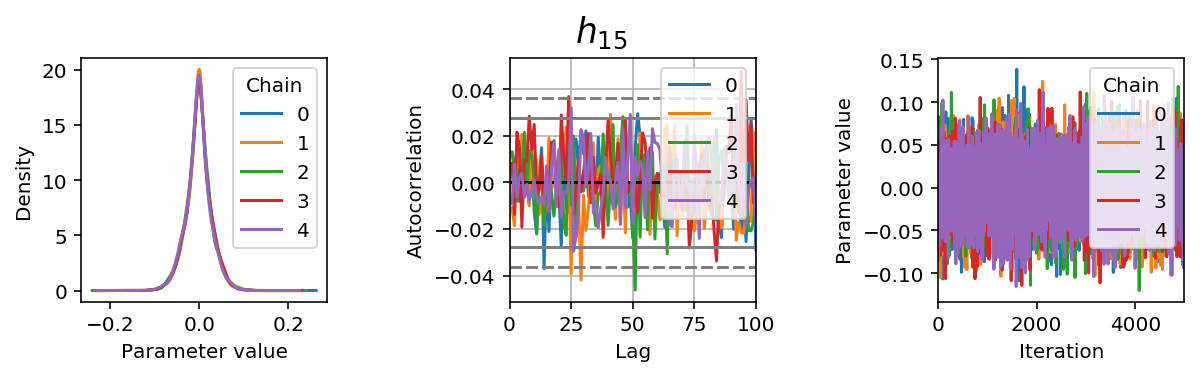

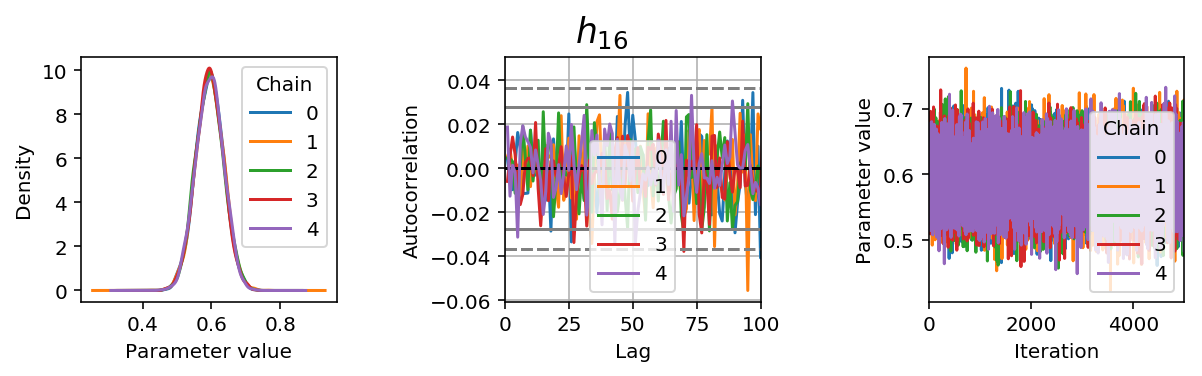

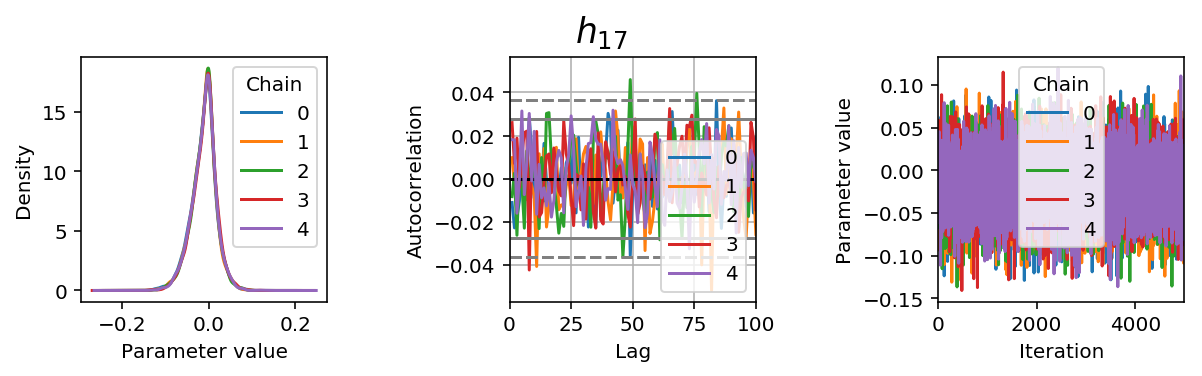

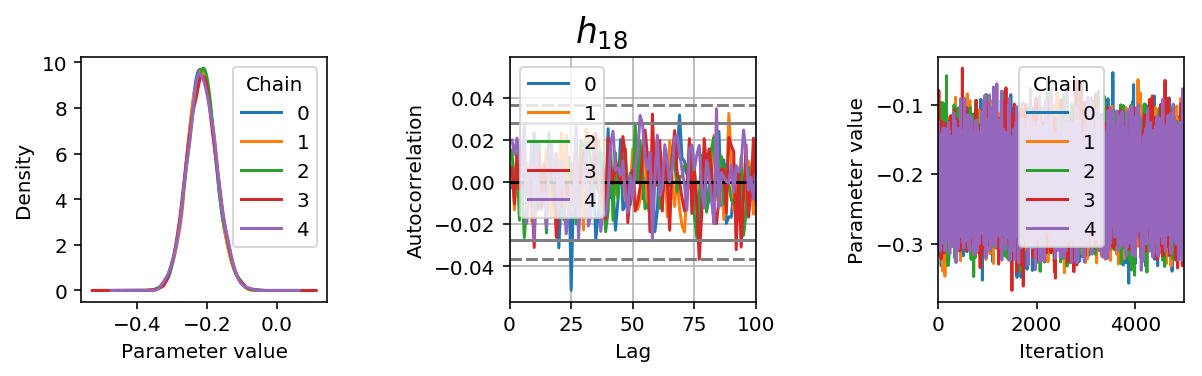

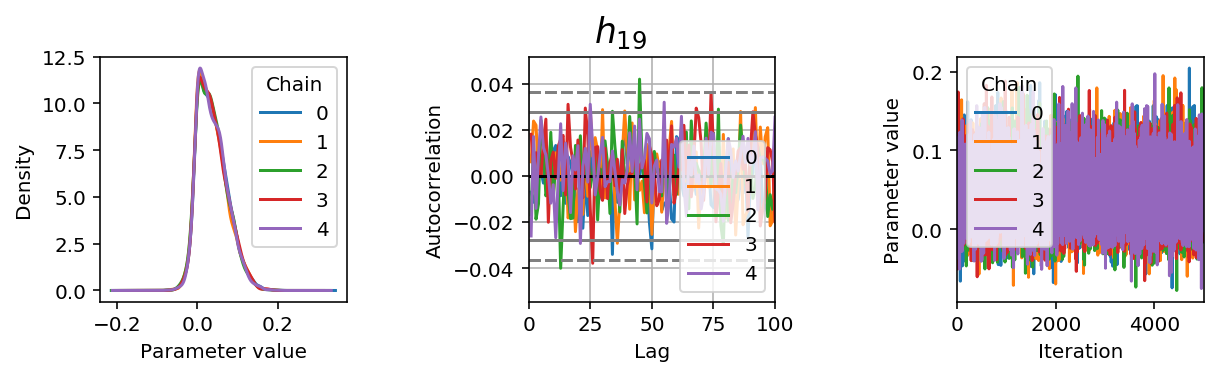

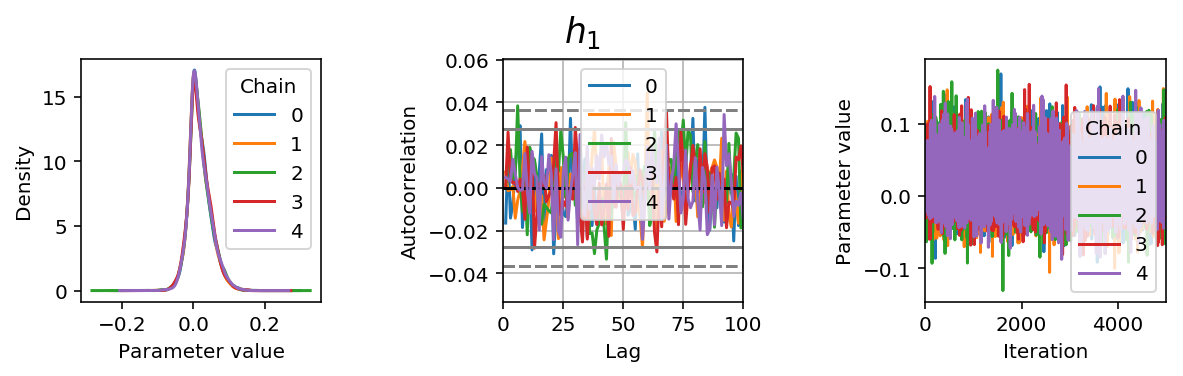

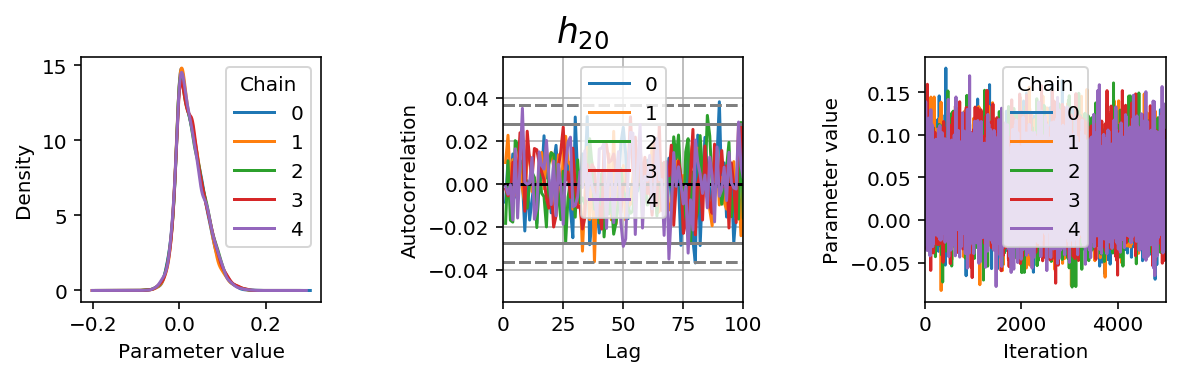

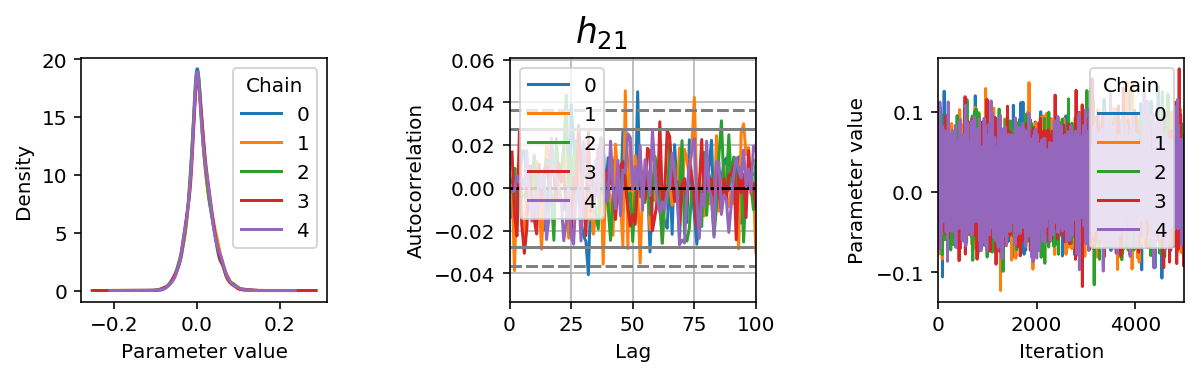

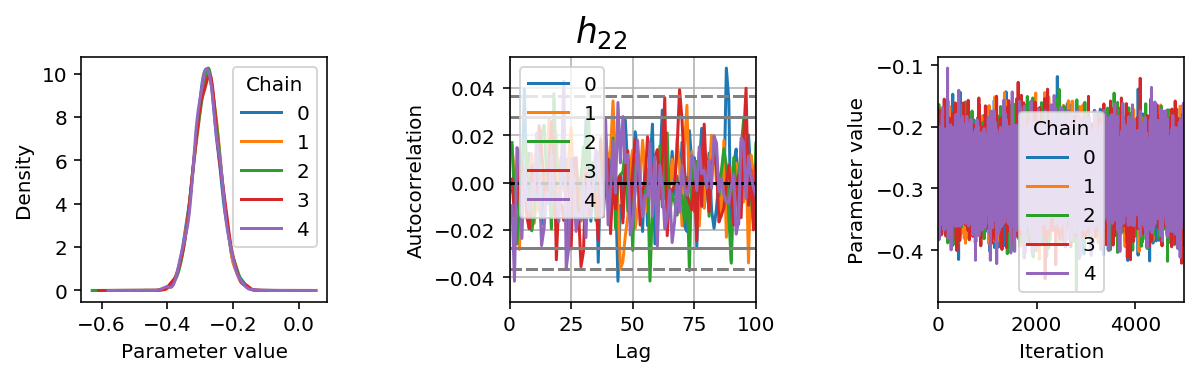

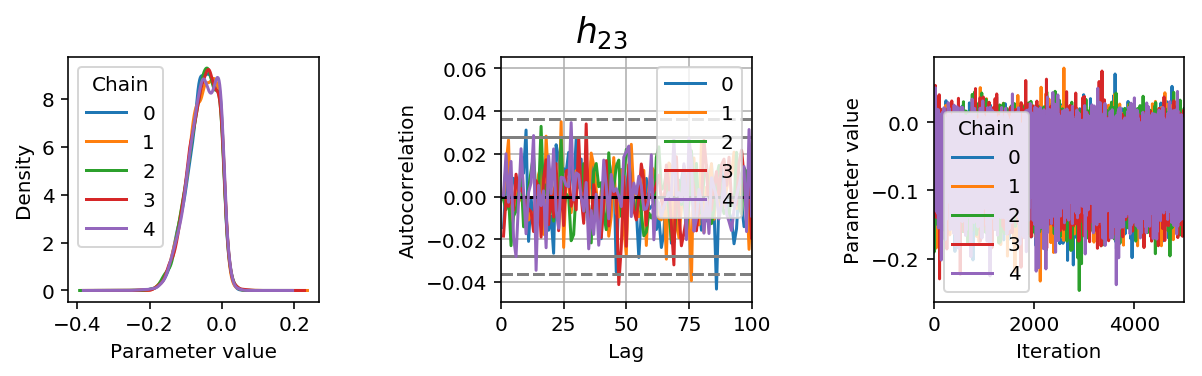

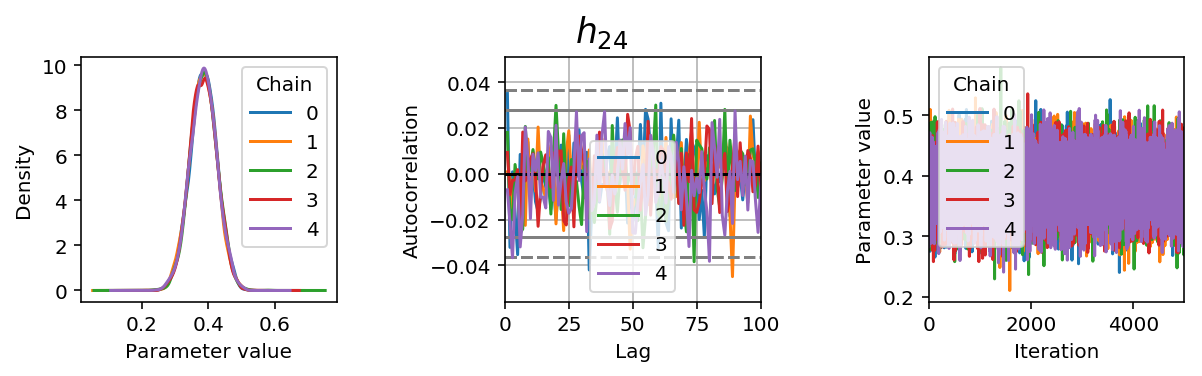

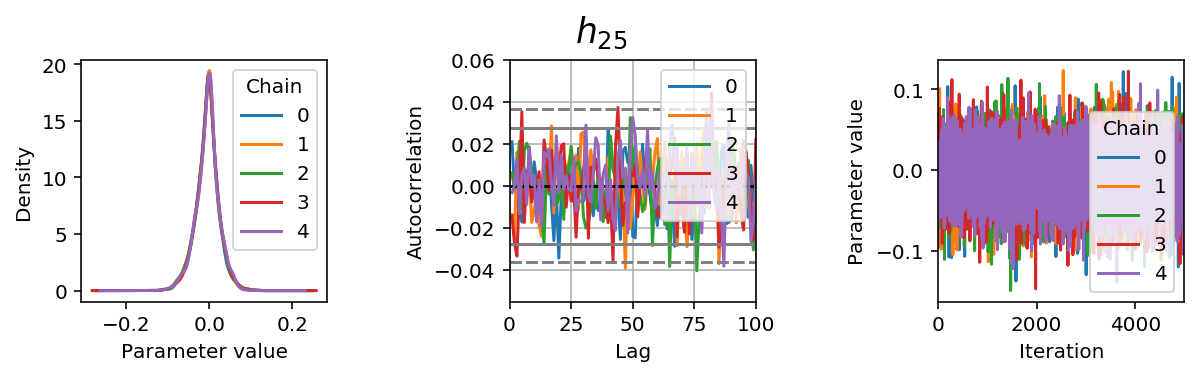

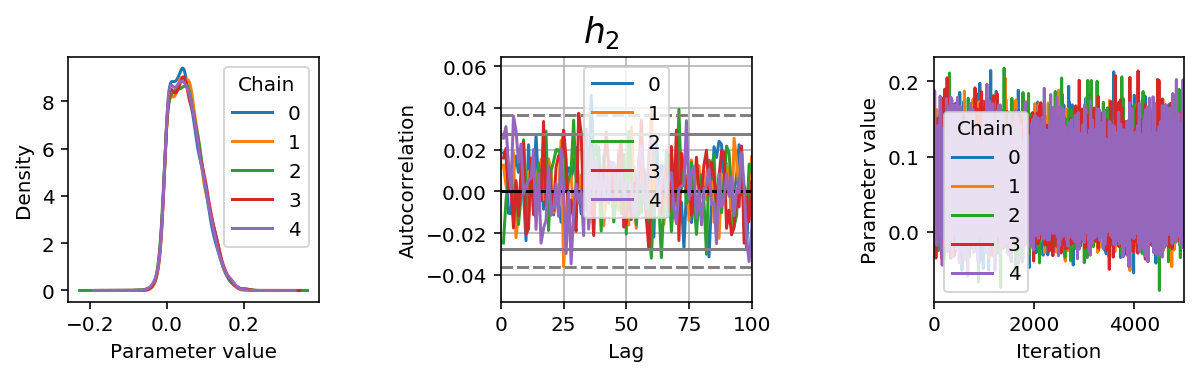

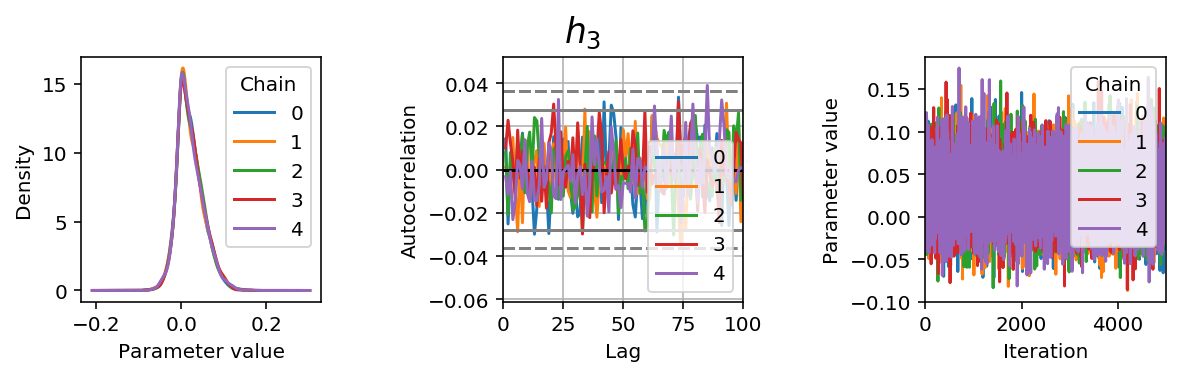

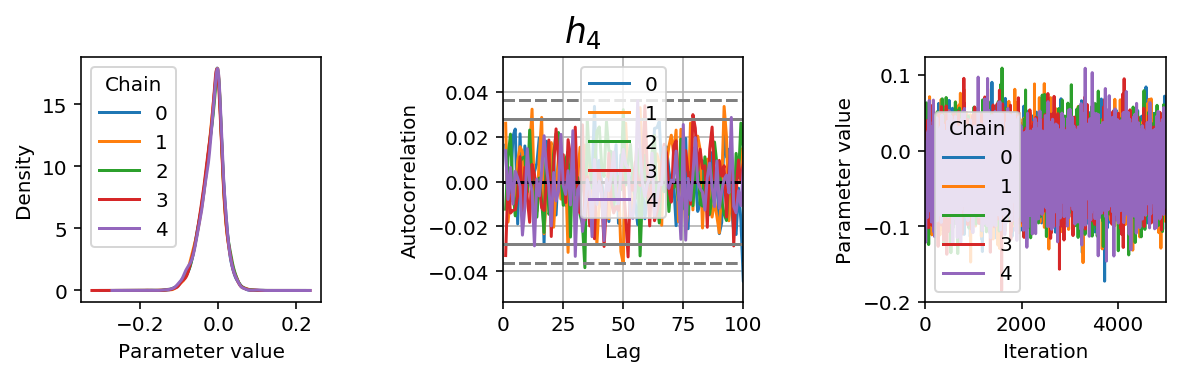

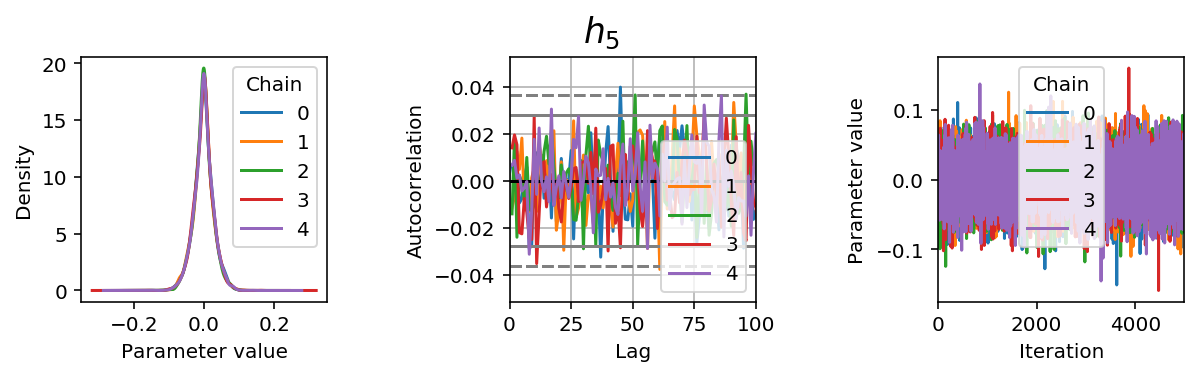

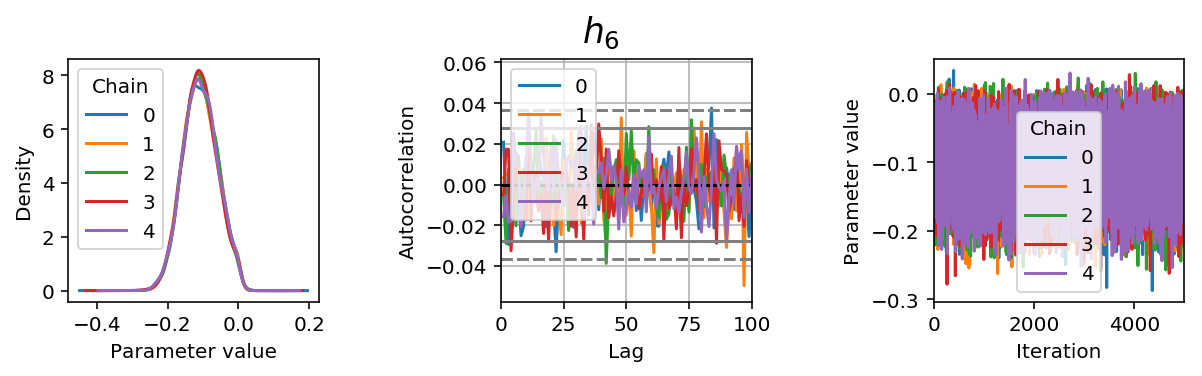

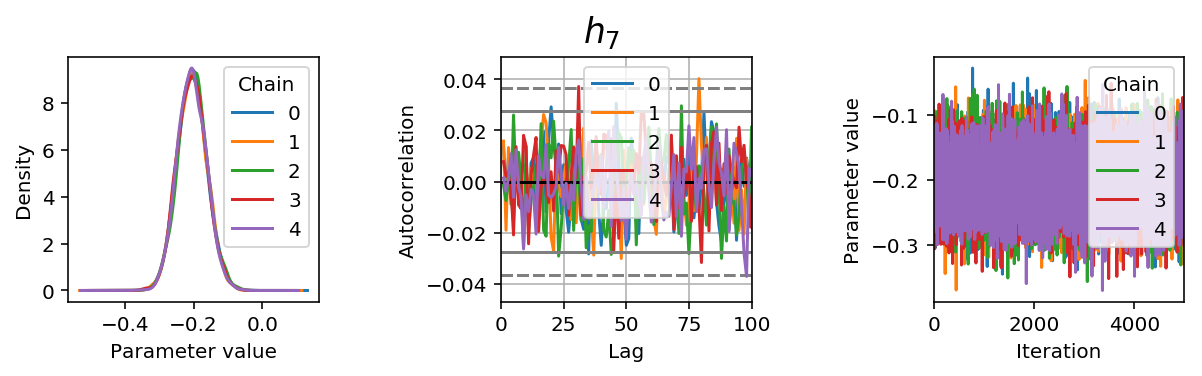

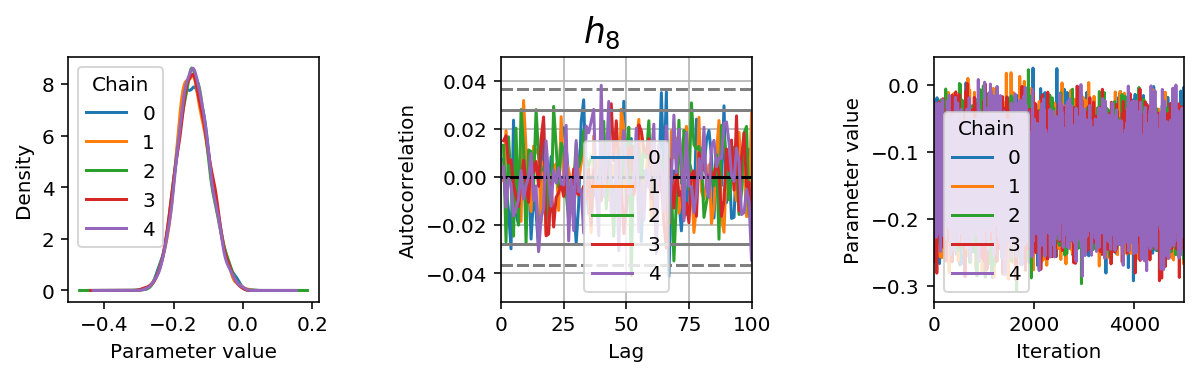

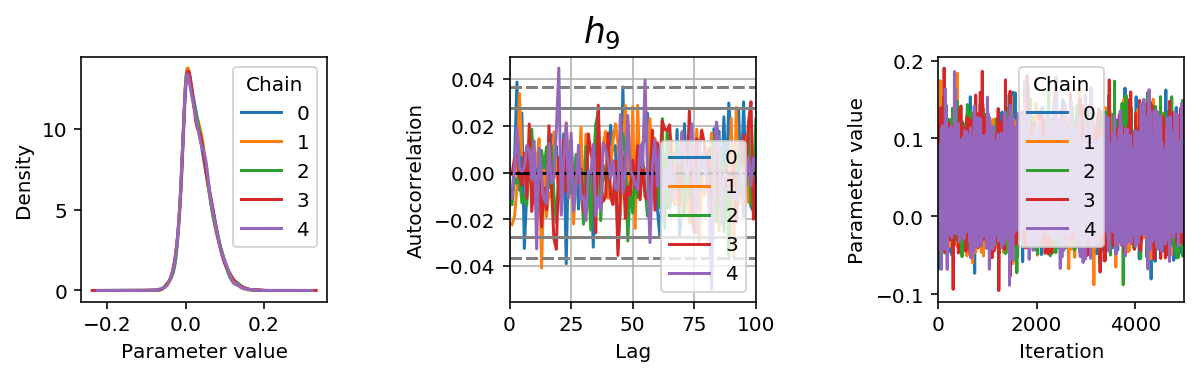

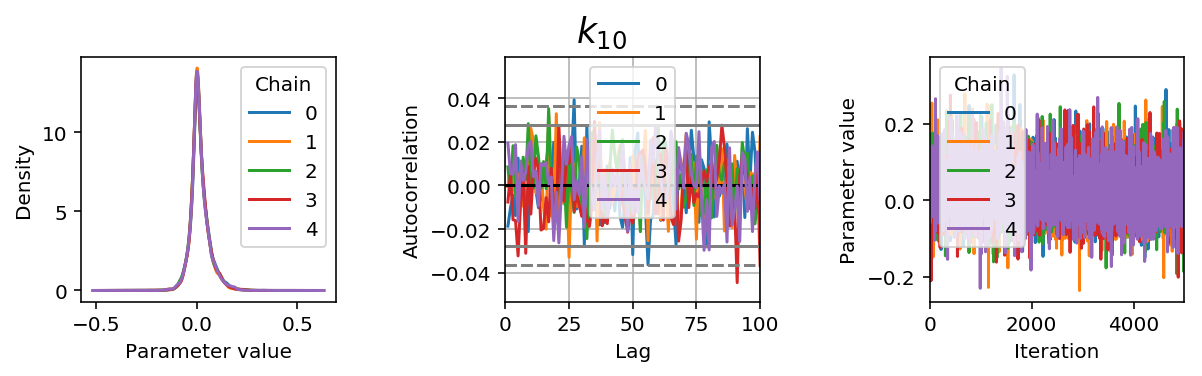

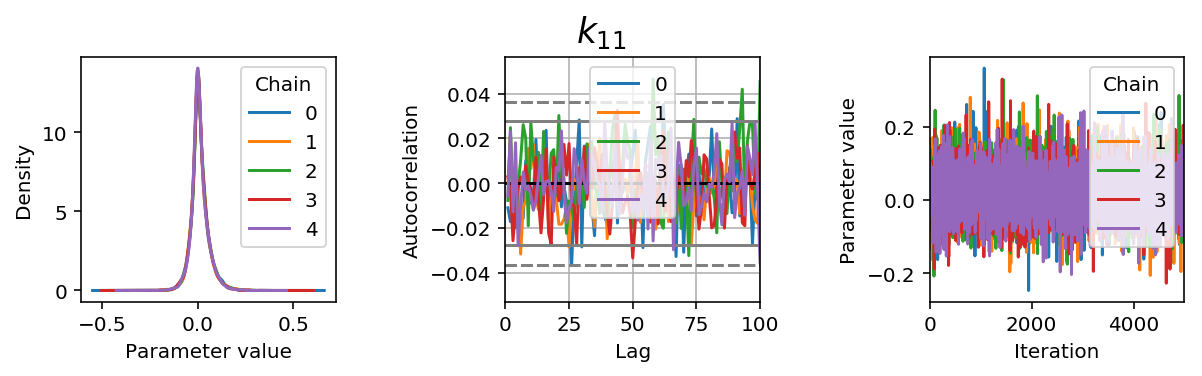

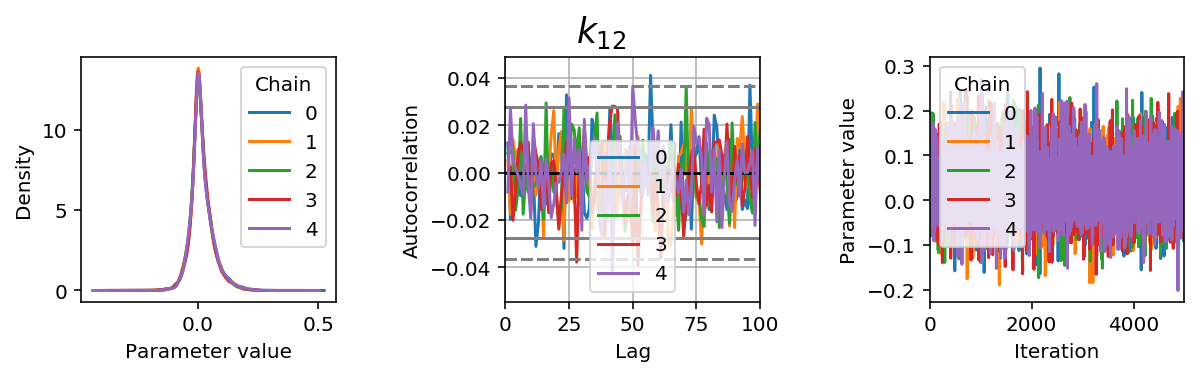

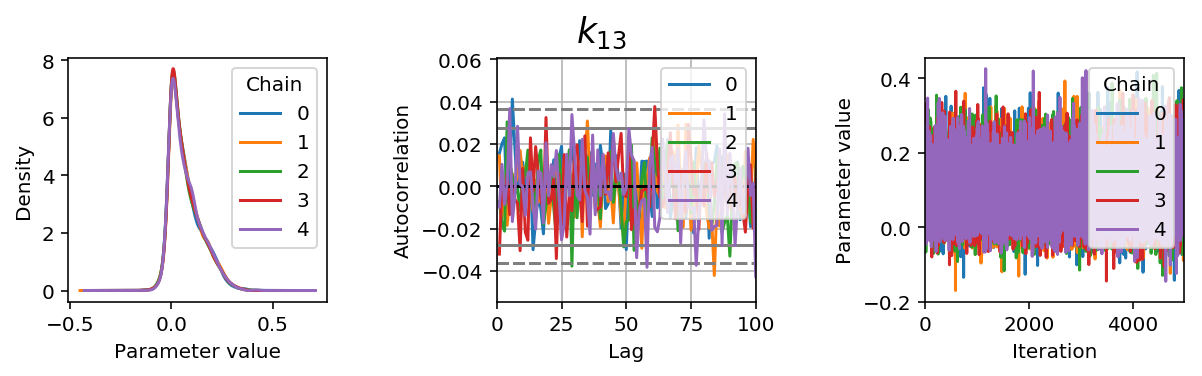

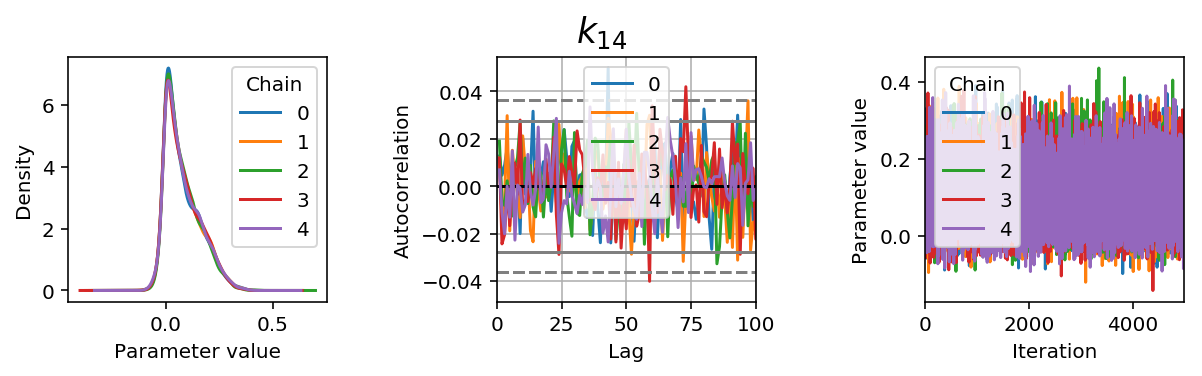

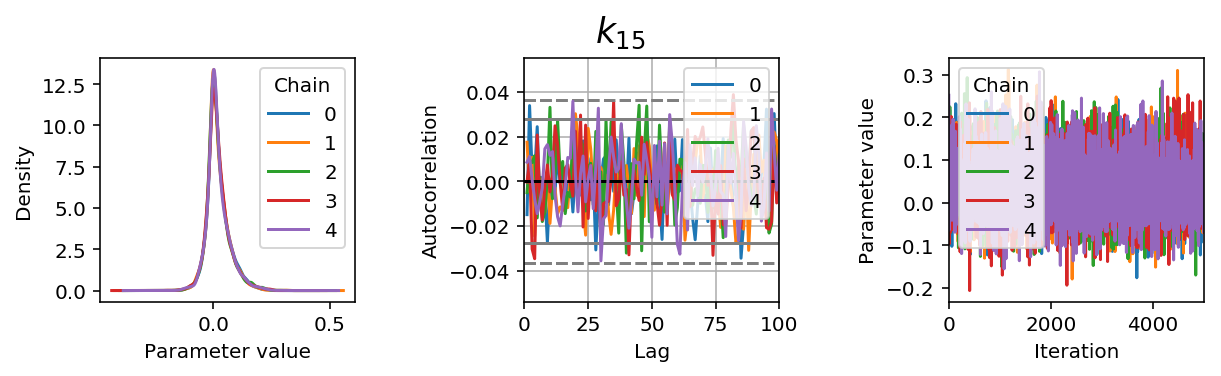

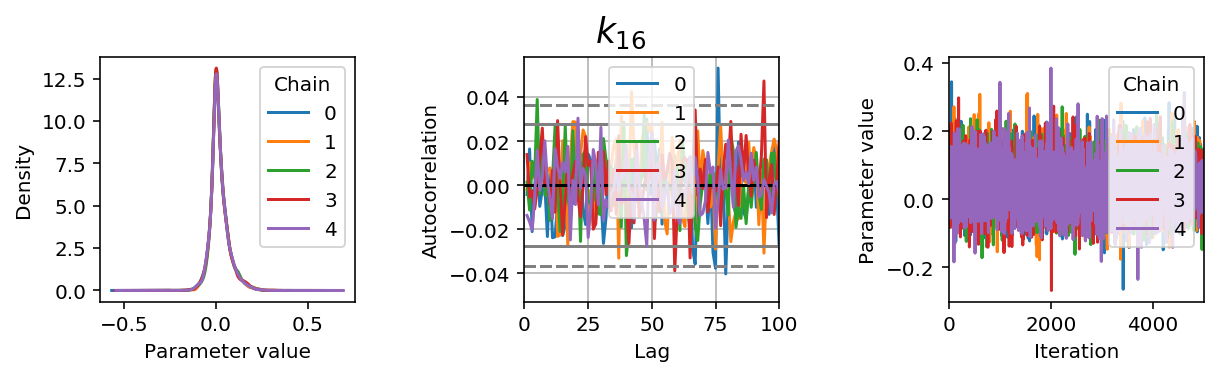

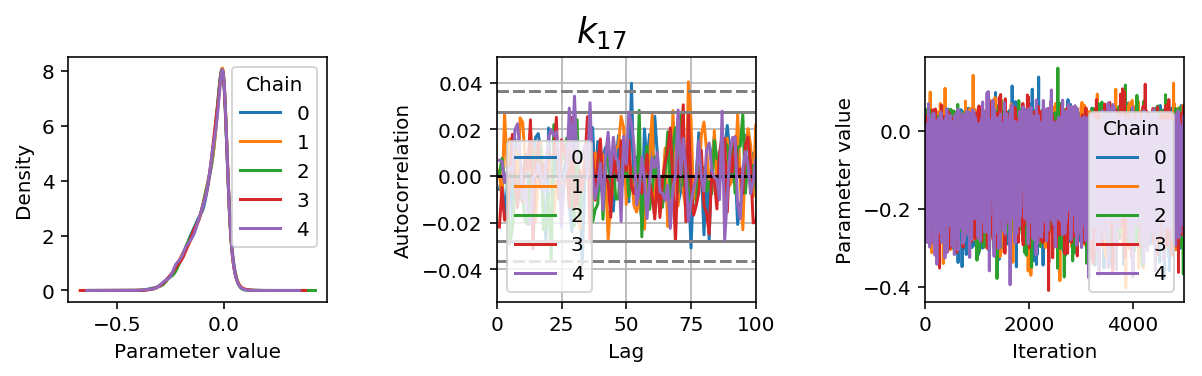

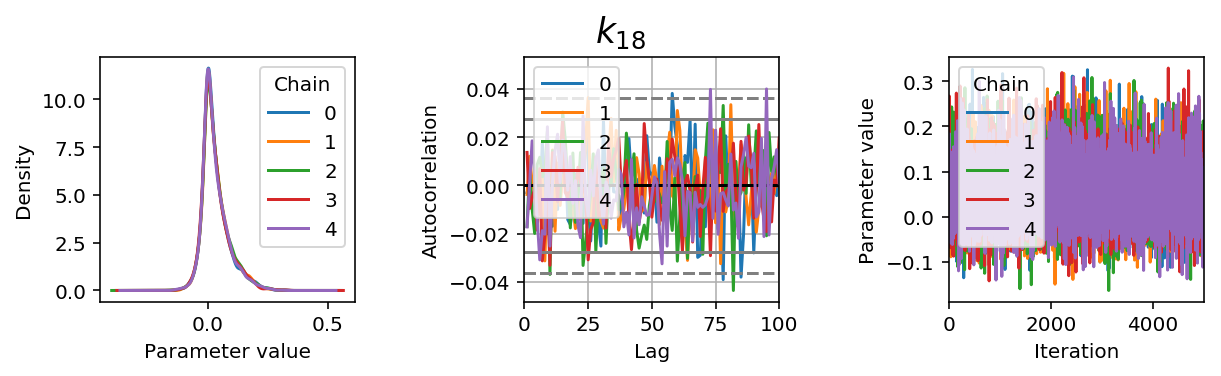

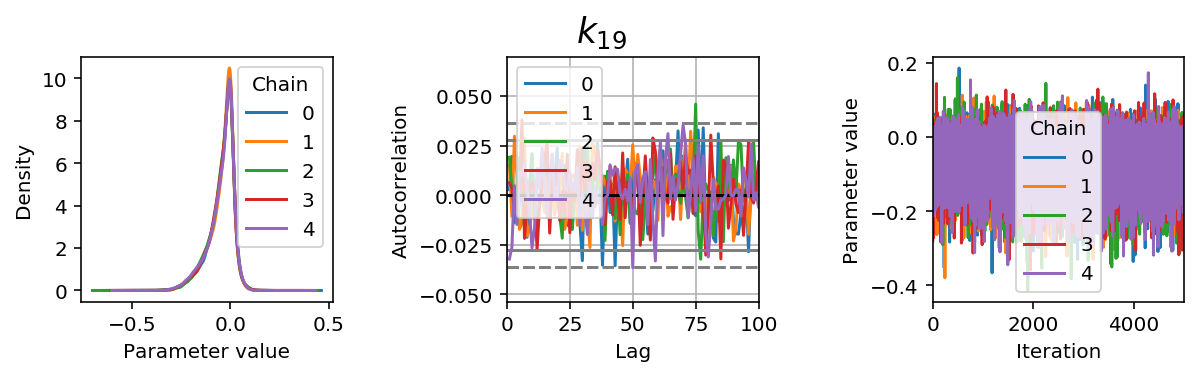

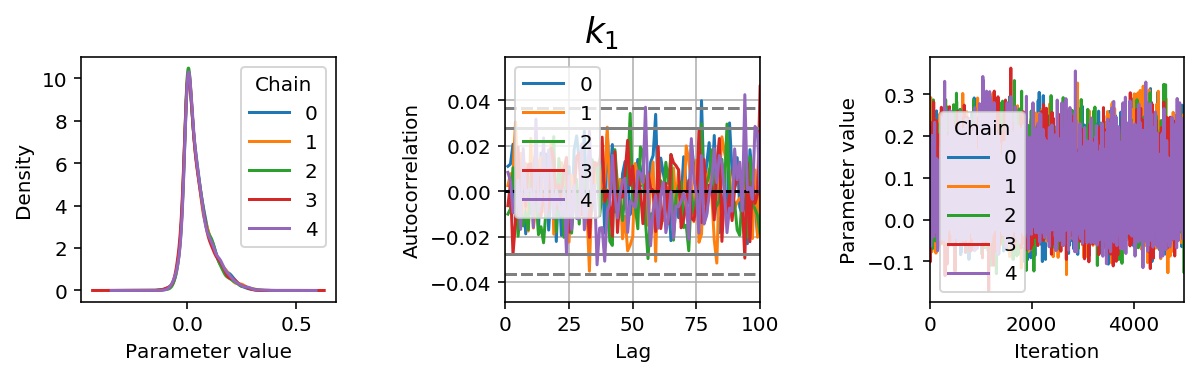

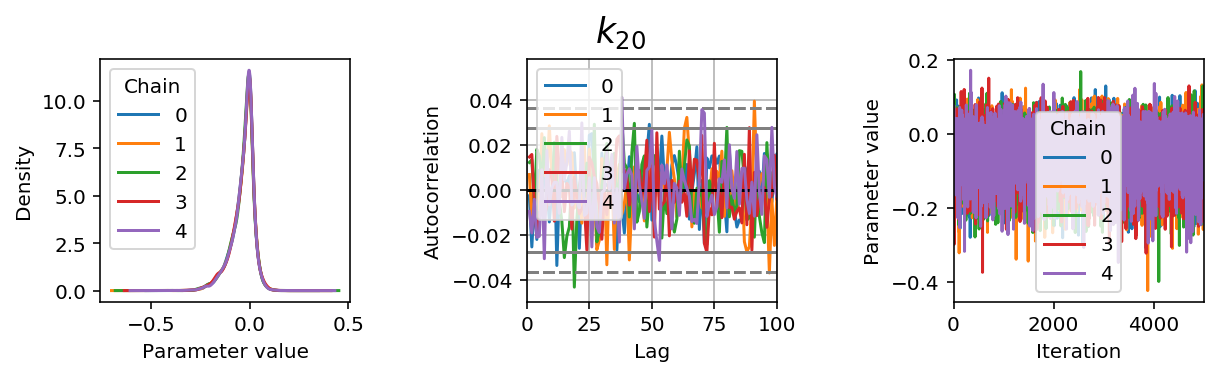

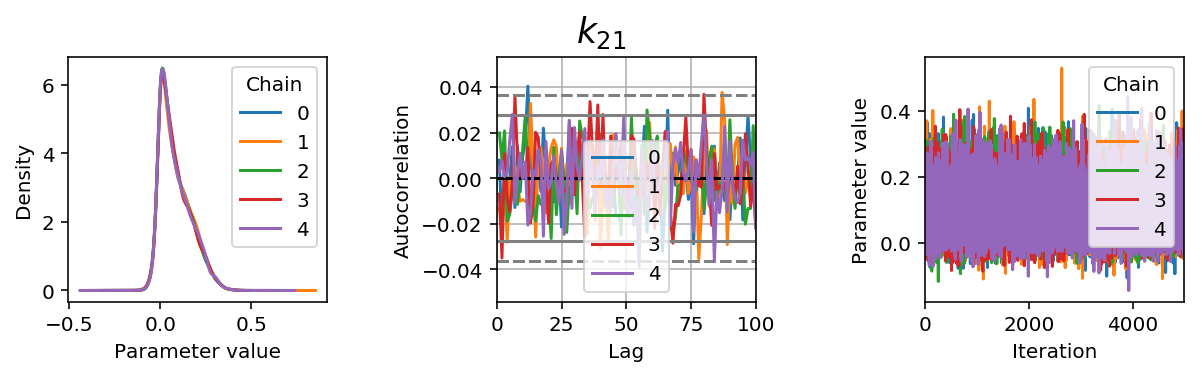

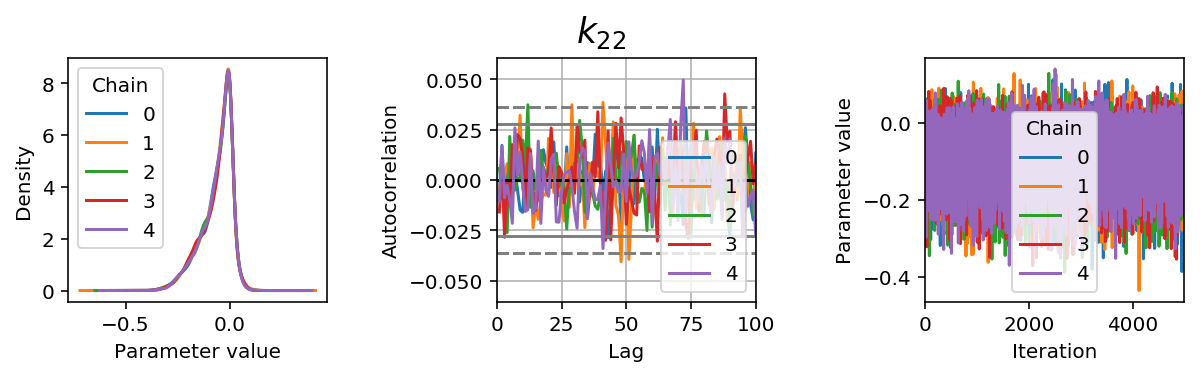

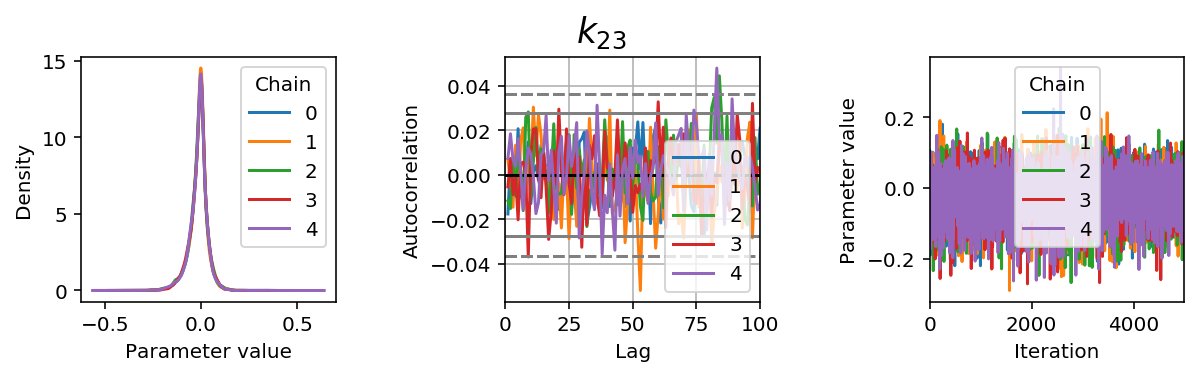

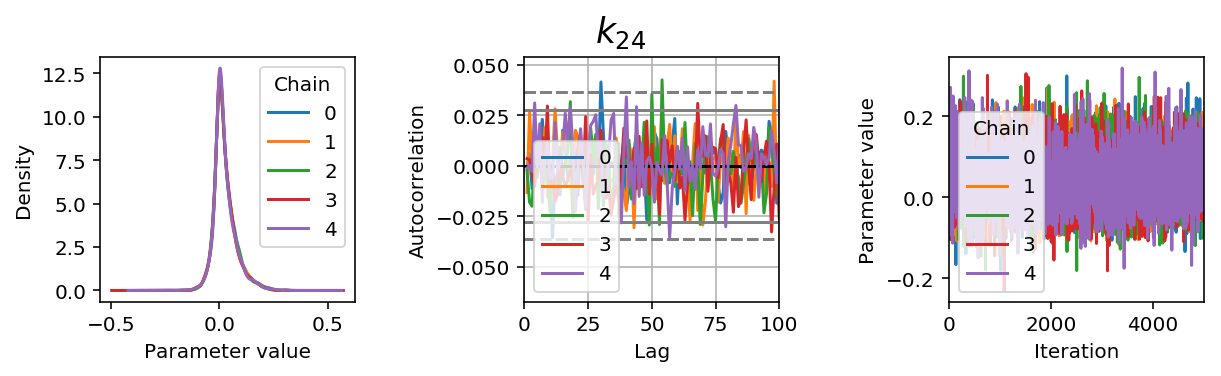

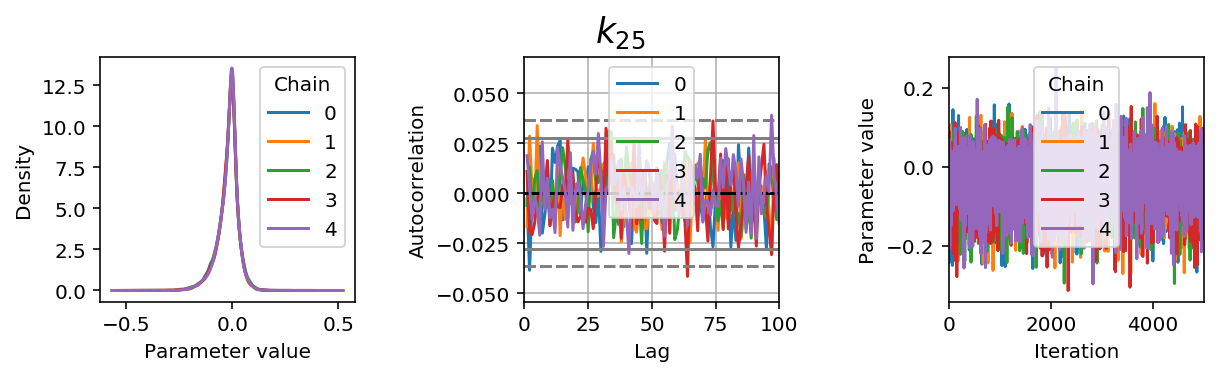

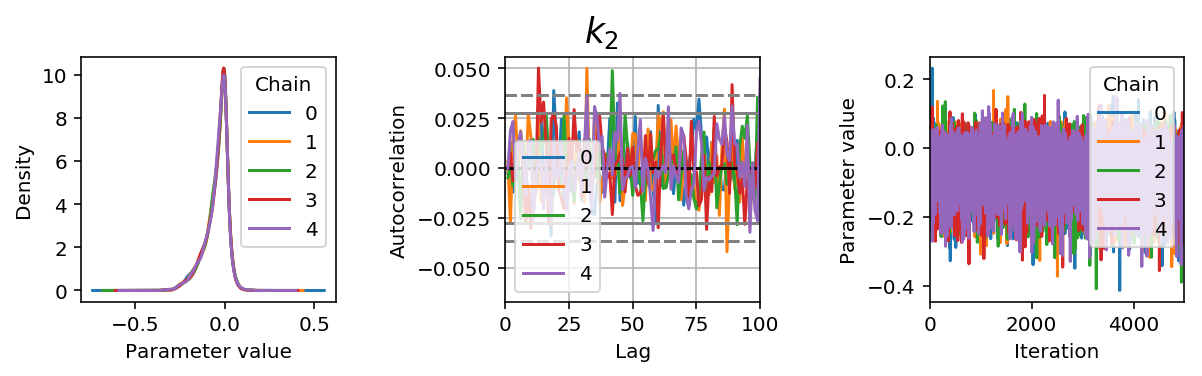

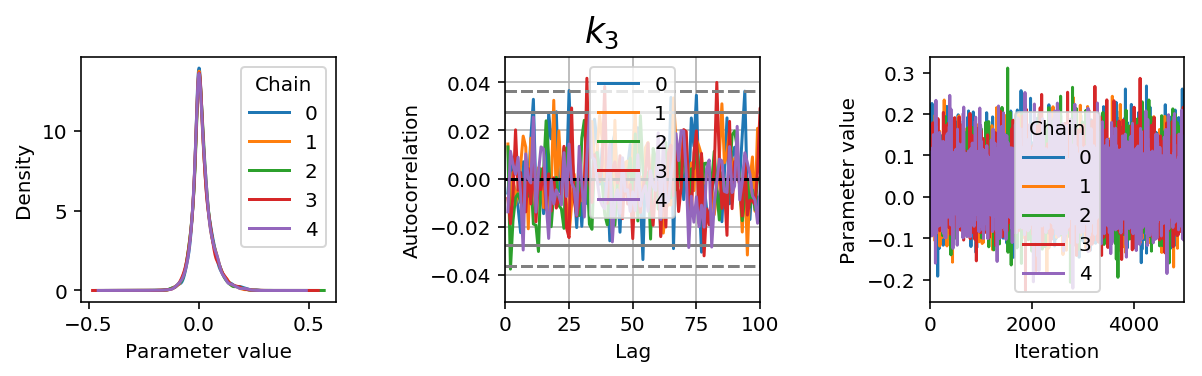

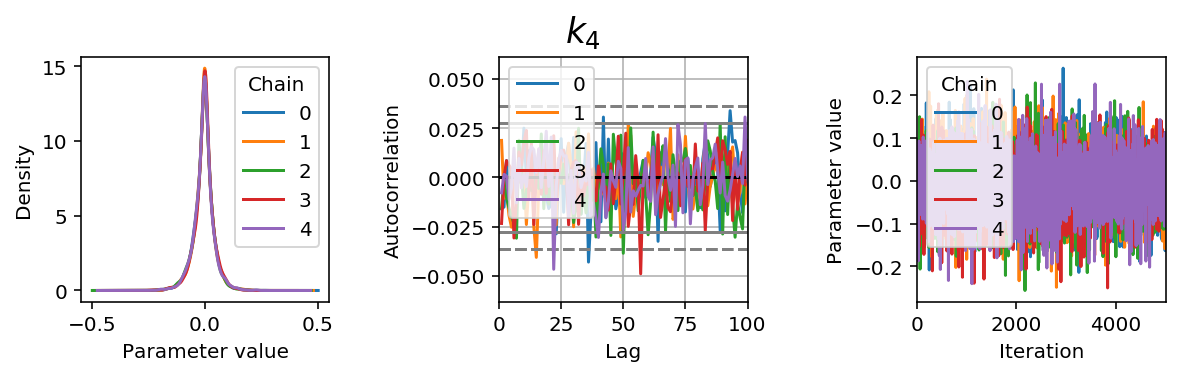

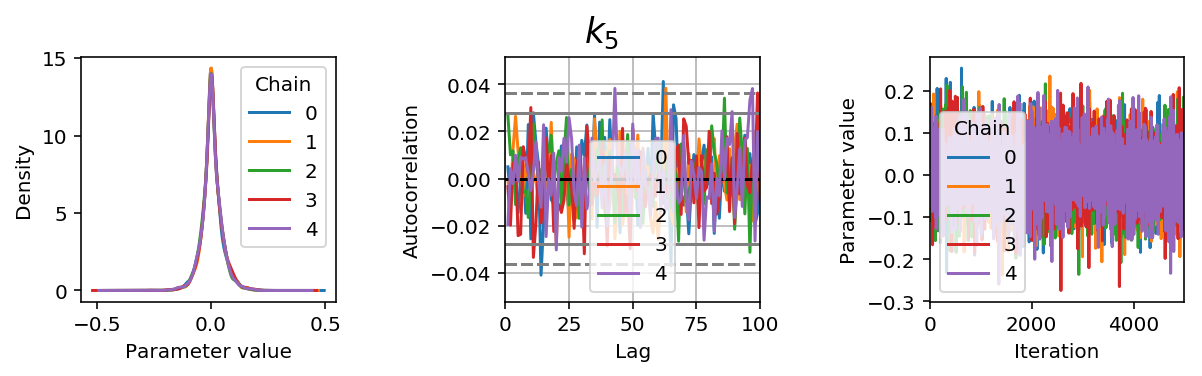

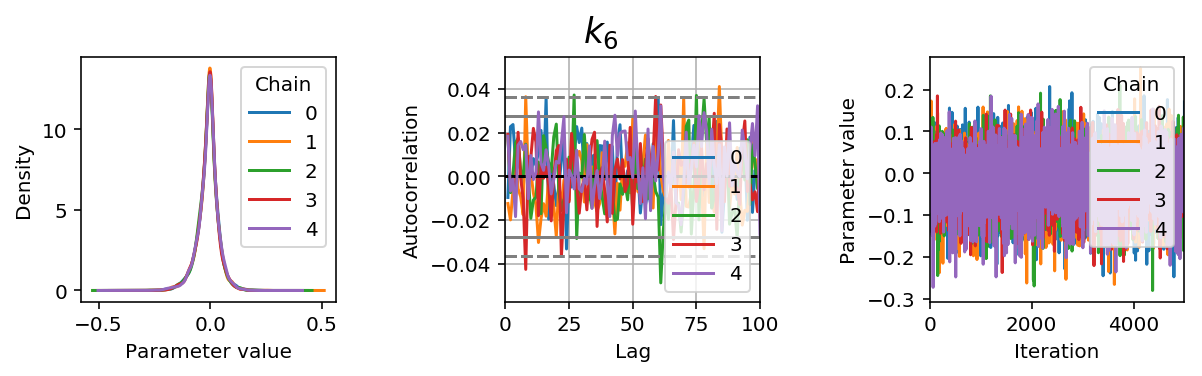

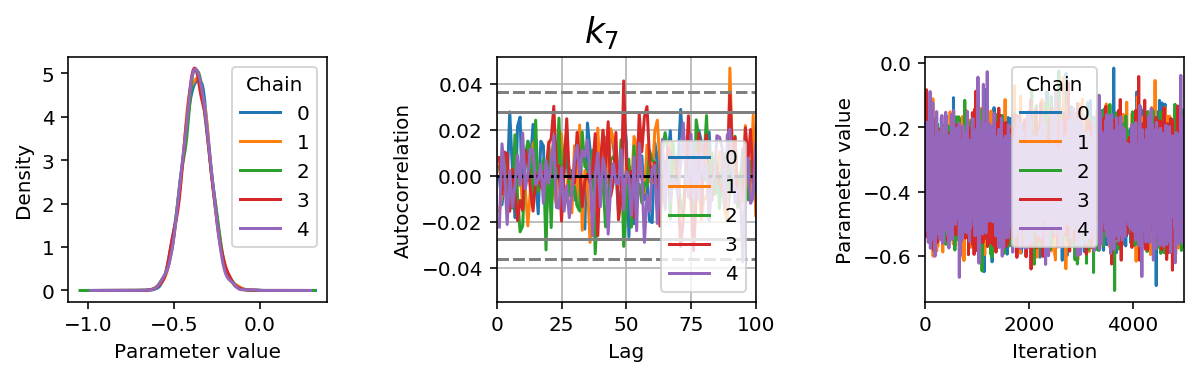

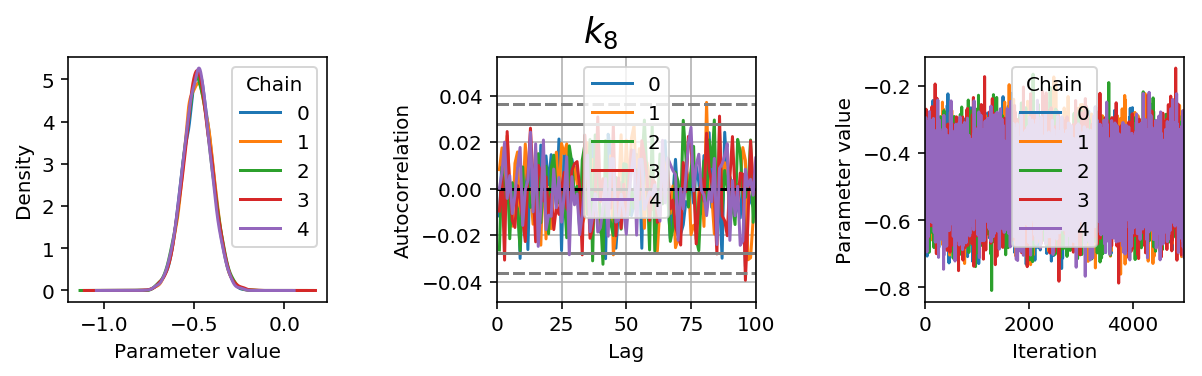

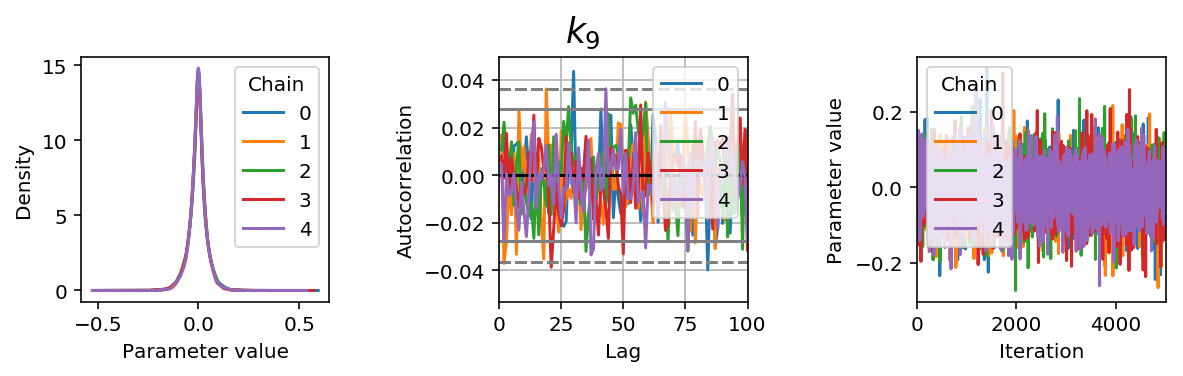

In [20]:
%%time
!date
## Use pandas three dimensional Panel to represent the trace:

trace_1_Stan = pd.Panel({k: v for k, v in samples_Nm2_trace_Stan.items()})
trace_1_Stan.axes[0].name = 'Variable'
trace_1_Stan.axes[1].name = 'Iteration'
trace_1_Stan.axes[2].name = 'Chain'
 
## Point estimates:
print(trace_1_Stan.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace_1_Stan.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('{}.png'.format(filename))
!date
# Display diagnostic plots
for var in trace_1_Stan:
    plot(trace_1_Stan, var);
 



In [ ]:
## adjust the thin varible to only look at every #th population element 
##Ndata is 25 use 
thin = 5
##Ndata is 20 use
#thin = 4
numHyperParams = 4

## Re-specify the dimension we want for our plot below, with thinning, for legibility.  
dim2 = int((Ndata/thin) + numHyperParams)
print(dim2)
print(k)
samples_Nm2_triangle_1_Stan = {}
truths_hhat = {}
truths_h = {}
for i in np.arange(0,Ndata,thin):
    print(i)
    print(samples_Stan['h'][:,i])
    print(samples_Stan['k'][:,i])
    print(h[i])
    print(k[i])
    print(hhat[i])
    print(khat[i])
    samples_Nm2_triangle_1_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i],'$k_{'+str(i+1)+'}$': samples_Stan['k'][:,i]})
    truths_hhat.update({'$h_{'+str(i+1)+'}$': hhat[i],'$k_{'+str(i+1)+'}$': khat[i]})
    truths_h.update({'$h_{'+str(i+1)+'}$': h[i],'$k_{'+str(i+1)+'}$': k[i]})
samples_Nm2_triangle_1_Stan.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})
truths_hhat.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})
truths_h.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})



In [22]:
print(samples_Nm2_triangle_1_Stan.keys())
print(int(dim2))
print(truths_hhat.values())

['$h_{16}$', '$k_{6}$', '$h_{21}$', '$h_{6}$', '$e_{\\sigma_{low}}$', '$k_{16}$', '$h_{1}$', '$h_{11}$', '$f_{low}$', '$f_{high}$', '$k_{1}$', '$k_{11}$', '$e_{\\sigma_{high}}$', '$k_{21}$']
9
[0.60591320640906765, -0.031405165295250788, 0.015764721938975081, -0.13316879303010865, array([ 0.00477651,  0.06913096,  0.03849837, ...,  0.04701906,
        0.00245572,  0.03435701]), 0.06093199655818967, 0.036698059880197746, -0.0052499908993665079, array([ 0.56432703,  0.73999392,  0.71645867, ...,  0.79441314,
        0.43867296,  0.67183077]), array([ 0.43567297,  0.26000608,  0.28354133, ...,  0.20558686,
        0.56132704,  0.32816923]), 0.11867355977055882, 0.037252490745928249, array([ 0.28333713,  0.3659383 ,  0.26765393, ...,  0.44951639,
        0.1756838 ,  0.28766773]), 0.1652836201557718]


In [43]:
%%time
!date

import triangle_linear
#data = np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2))
#print(np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2)).shape)

samples_Nm2_triangle_2_Stan = {}    
for j, i in samples_Nm2_triangle_1_Stan.items():
    samples_Nm2_triangle_2_Stan.update({str(j): i.reshape(-1,1)})
    
data = None
for k, v in samples_Nm2_triangle_2_Stan.items():
    column = v.reshape(-1,1)
    if data is None:
        data = column
    else:
        data = np.hstack((data, column))

print(data[:].shape)
print(len(truths_hhat.keys()))
print(len(samples_Nm2_triangle_2_Stan.keys()
!date

Tue Jan 30 17:05:46 PST 2018
(25000, 14)
14
14
Tue Jan 30 17:05:47 PST 2018
CPU times: user 29.3 ms, sys: 37.3 ms, total: 66.7 ms
Wall time: 331 ms


In [ ]:
%%time
!date

figure = triangle_linear.corner(data,labels=samples_Nm2_triangle_2_Stan.keys(),labelsy=samples_Nm2_triangle_2_Stan.keys(), truths=truths_hhat.values(), truths_color = 'black')

plt.savefig('triangle_linear_Nm2_Stan.png')

!date

<h2 align="center">Part 2: Explore Matt Trick or non-centered parameterization </h2>

This is probably not necessary for this model.  The generative model is Normal centered at zero.  

In [ ]:
eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
}

parameters {
    simplex[2] f;
    real<lower=0> e_sigma[2];
    real<lower=-1,upper=1> h[Ndata];
    real h_tilde[Ndata];

}


model {
    e_sigma ~ uniform(0, 1.0);
    h_tilde ~ normal(0, 1);

    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);

    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[1], normal_log(h[n], 0.0, e_sigma[1] * h_tilde[n]), normal_log(h[n], 0.0, e_sigma[2] * h_tilde[n])));
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)